# Data Challenge for Pricing Test
## 1. Introduction

Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. In the experiment, 66\% of the users have seen the old price (39), while a random sample of 33\% users a higher price (59). In this notebook, we will disscuss the results of this A/B testing and provide answers for the following questins:

1) Should the company sell its software for 39 or 59?
2) What are the main findings looking the data?
3) After how many days we would have stopped the test?

## 2. Features

There are three main features in this A/B Testing besied the price, including source, device and operating system. For each feature, I will visulize the sample distribution first then analyze the convert rate distribution and average revenue distribution

### 2.1 Source
There are 12 types of source in this dataset. The distribution of different sources are similar at control and experimental groups. But it is not fully randomnized in 12 sources.
The highest convert rate and average revenue comes from friend referral.

### 2.2 Device
There are 2 types of device in this dataset.  More samples are from mobile than from web. The control group has a little higher ratio of mobile samples than web samples.
The convert rate doesn't show a significant difference between 2 type of device.

### 2.3 Operating System
There are 6 types of operating sysytem. The distribution of different operating system is slight different between control and experimental groups. And the samples are not randonly distributed in 6 operating systems.
The convert rate of Mac and IOS are higher than other types of operating system.
There is one thing which need to be noticed, there is no convert rate from Linux system in experimental system.

## 3 Conclusions
From the p-value of T-test between control group and experimental group, it showed significant difference that higher price (59) can bring more revenue to the company. But we need to be careful about the biased data from different sources and operating systems. It may be necessary to validate if it is the true distribution of real data. Also in the future, the company can think about different marketing plans for friend referral and Apple users. We should also send the technique deparment to check the experiment website for Linux users. At last, we may be able to end the A/B testing at Week 2 or Week 5 depends on the budget.

### Loading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from scipy import stats
import math
import numpy as np

In [2]:
# read test results in pandas dataframe
test_results = pd.read_csv("./Pricing_Test/test_results.csv")
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
# read user table in pandas dataframe
user_table = pd.read_csv("./Pricing_Test/user_table.csv")
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
user_table.dtypes

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object

In [5]:
test_results.dtypes

user_id              int64
timestamp           object
source              object
device              object
operative_system    object
test                 int64
price                int64
converted            int64
dtype: object

In [6]:
len(user_table)

275616

In [7]:
# check if there is any duplicate data in user table
user_table.nunique()

user_id    275616
city          923
country         1
lat           713
long          830
dtype: int64

In [8]:
# Check if there is any missing data in user table
missing_values_count = user_table.isnull().sum()
missing_values_count

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [9]:
len(test_results)

316800

In [10]:
# check if there is any duplicate data
test_results.nunique()

user_id             316800
timestamp           140931
source                  12
device                   2
operative_system         6
test                     2
price                    2
converted                2
dtype: int64

In [11]:
# Check if there is any missing data
missing_values_count = test_results.isnull().sum()
missing_values_count

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [12]:
data = test_results.join(user_table.set_index('user_id'),how = "left", on="user_id")
print(len(test_results) - len(user_table))
data.head()

41184


,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [13]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [14]:
test_results.loc[test_results["user_id"] == 604839]

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0


In [15]:
user_table.loc[user_table["user_id"] == 604839]

,user_id,city,country,lat,long
104734,604839,Buffalo,USA,42.89,-78.86


In [16]:
data_missing_id = data[data.isnull().any(axis=1)]
data_missing_id.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
12,425567,2015-04-24 10:09:04,ads_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
21,899236,2015-05-03 02:31:06,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
38,307166,2015-05-30 13:47:15,seo_facebook,mobile,iOS,1,59,0,NaN,NaN,NaN,NaN
50,833445,2015-04-11 17:07:35,direct_traffic,mobile,iOS,0,39,0,NaN,NaN,NaN,NaN


In [17]:
test_results["source"].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other'], dtype=object)

In [18]:
test_results["operative_system"].unique()

array(['iOS', 'android', 'mac', 'windows', 'other', 'linux'], dtype=object)

In [19]:
data["city"].nunique()

923

I find out that there is part of user information missing in the dataset, also the location of users are based on cities not states so the user information may not be useful in this analysis.

Now, let's check if there is any mislabeled data by checking "test" column and "price" column.

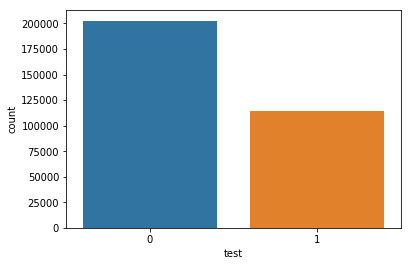

0    202727
1    114073
Name: test, dtype: int64


In [20]:
sns.countplot(test_results["test"])
plt.show()
print(test_results["test"].value_counts())

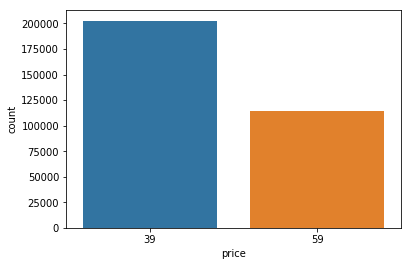

39    202672
59    114128
Name: price, dtype: int64


In [21]:
sns.countplot(test_results["price"])
plt.show()
print(test_results["price"].value_counts())

In [22]:
data[['price', 'test', 'user_id']].groupby(['test', 'price'])['user_id'].count().reset_index(name="number of users")

,test,price,number of users
0,0,39,202517
1,0,59,210
2,1,39,155
3,1,59,113918


In [23]:
data_clean = data.loc[((test_results["price"] == 39) & (test_results["test"] == 0)) | ((test_results["price"] == 59) & (test_results["test"] == 1))]
print(len(data_clean))

316435


From the above table, we can clearly see that there are 365 mislabeled data. We need to remove those before our analysis.

In [24]:
# Add revenue information in the dataframe
data_clean["revenue"] = data_clean["price"] * data_clean["converted"]
data_clean.head()

/Users/hao/.pyenv/versions/3.6.4/envs/test_tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [25]:
data_temp1 = data[['user_id','source','test']].groupby(['test','source'])["user_id"].nunique().reset_index(name="number of users")
data_temp1.head(24)

,test,source,number of users
0,0,ads-bing,14609
1,0,ads-google,37864
2,0,ads-yahoo,4818
3,0,ads_facebook,34099
4,0,ads_other,19284
5,0,direct_traffic,38759
6,0,friend_referral,13135
7,0,seo-bing,1334
8,0,seo-google,15102
9,0,seo-other,5889


In [26]:
data_temp2 = data[['user_id','source','test']].groupby(['test'])["user_id"].nunique().reset_index(name="total number of users")
data_temp2.head(24)

,test,total number of users
0,0,202727
1,1,114073


### Source
In this section, I will visualize the data from different sources

In [27]:
# Calculate sample ratio for different sources
data_temp = data[['user_id','source','test']].groupby(['test','source'])["user_id"].nunique().reset_index(name="ratio")
data_temp1 = data_temp.groupby(['test', 'source']).agg({'ratio': 'sum'})
data_source = data_temp1.groupby(level=0).apply(lambda x: 1.0 * x / float(x.sum()))
data_source.reset_index(level = [0,1], inplace = True)
data_source.head(24)

,test,source,ratio
0,0,ads-bing,0.072062
1,0,ads-google,0.186773
2,0,ads-yahoo,0.023766
3,0,ads_facebook,0.168202
4,0,ads_other,0.095123
5,0,direct_traffic,0.191188
6,0,friend_referral,0.064792
7,0,seo-bing,0.006580
8,0,seo-google,0.074494
9,0,seo-other,0.029049


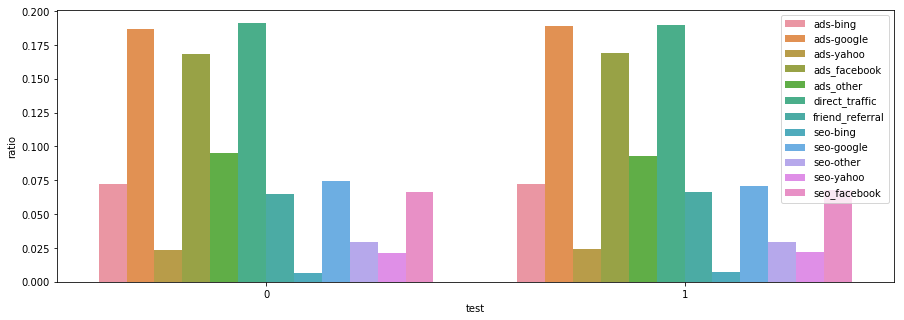

In [28]:
# Plot the sample distribution over different sources using bars.
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='test', y='ratio', hue='source', data=data_source, ax = ax)
ax.legend(loc=1)

Text(0.5, 1.0, 'Sample ratio over sources')

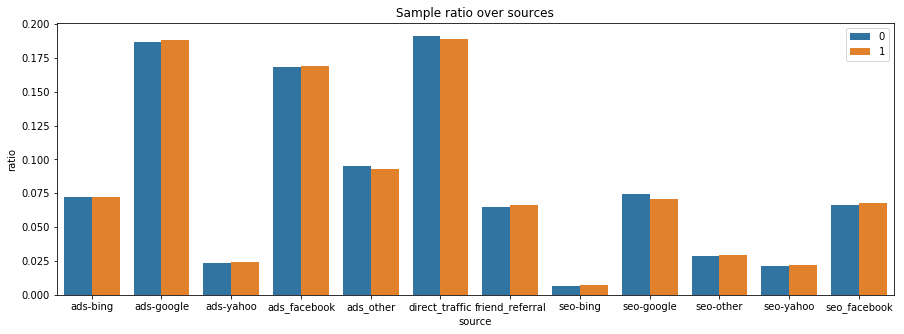

In [29]:
# Compare the sample distribution between control group and test group over different sources.
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='source', y='ratio', hue='test', data=data_source, ax=ax)
ax.legend(loc=1)
ax.set_title('Sample ratio over sources')

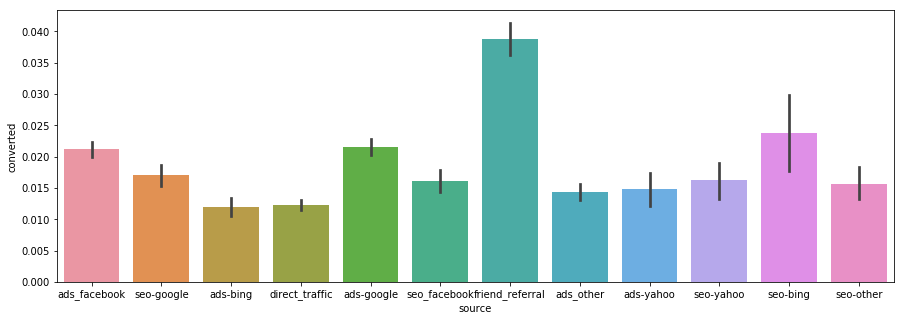

In [30]:
# Plot the average convert rate of all samples over different sources
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(y='converted', x='source', data=data_clean, ax=ax)

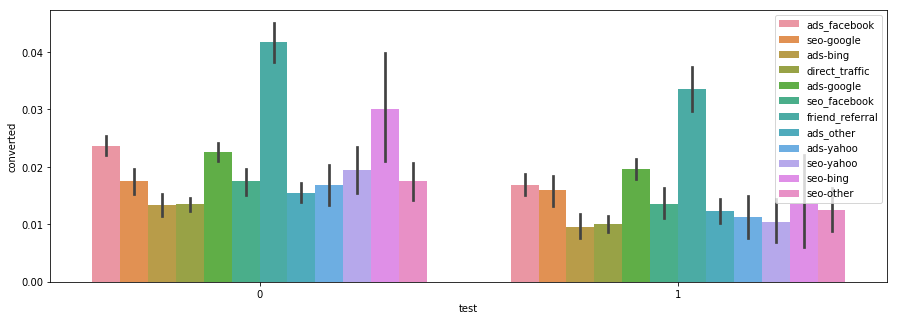

In [31]:
# Plot the average convert rate of two groups over different sources
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='test', y='converted', hue='source', data=data_clean, ax=ax)
ax.legend(loc=1)

Text(0.5, 1.0, 'Average convert rate over sources')

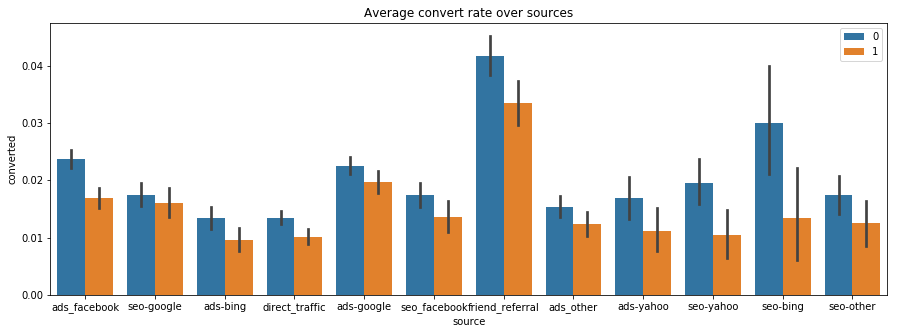

In [32]:
# Plot the average convert rate of control group and test group over different sources
_, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x='source', y='converted', hue='test', data=data_clean)
ax.legend(loc=1)
ax.set_title('Average convert rate over sources')

Text(0.5, 1.0, 'Average revenue over sources')

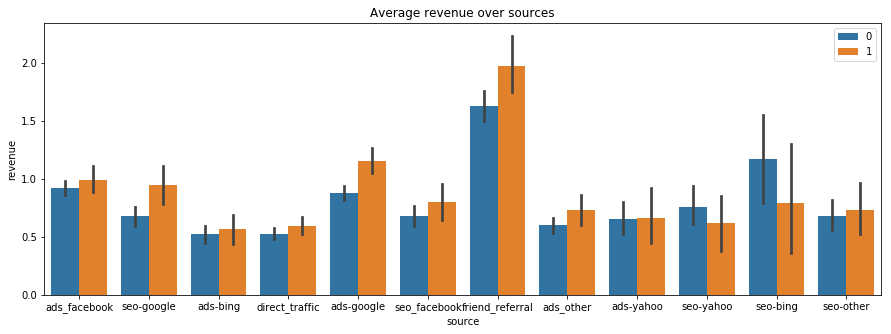

In [33]:
# Plot the average revenue of control group and test group over different sources
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='source', y='revenue', hue='test', data=data_clean, ax=ax)
ax.legend(loc=1)
ax.set_title('Average revenue over sources')

#### Friend referral can bring highest revenue among all sources

### Device
In this section, I will visualize the data from different sources.

In [34]:
# Calculate sample ratio for different devices
data_temp = data[['user_id','device','test']].groupby(['test','device'])["user_id"].nunique().reset_index(name="ratio")
data_temp1 = data_temp.groupby(['test', 'device']).agg({'ratio': 'sum'})
data_device = data_temp1.groupby(level=0).apply(lambda x: 1.0 * x / float(x.sum()))
data_device.reset_index(level = [0,1], inplace = True)
data_device.head(24)

,test,device,ratio
0,0,mobile,0.594302
1,0,web,0.405698
2,1,mobile,0.578489
3,1,web,0.421511


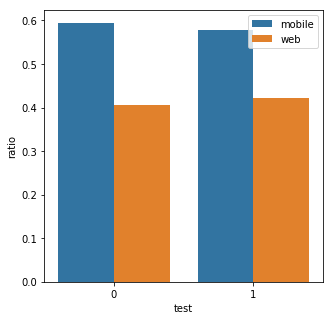

In [35]:
# Plot the sample distribution over different devices using bars.
_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='test', y='ratio', hue='device', data=data_device, ax=ax)
ax.legend(loc=1)

Text(0.5, 1.0, 'Sample ratio over devices')

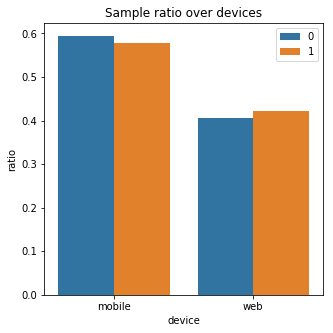

In [36]:
# Compare the sample distribution between control group and test group over different devices.
_, axes = plt.subplots(figsize=(5, 5))
ax = sns.barplot(x='device', y='ratio', hue='test', data=data_device)
ax.legend(loc=1)
ax.set_title('Sample ratio over devices')

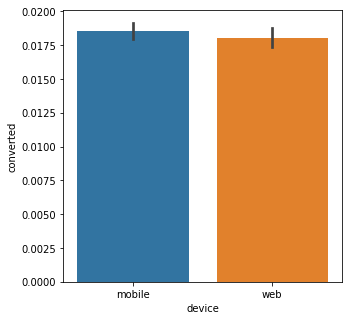

In [37]:
# Plot the average convert rate of all samples over different devices
_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='device', y='converted', data=data_clean, ax=ax)

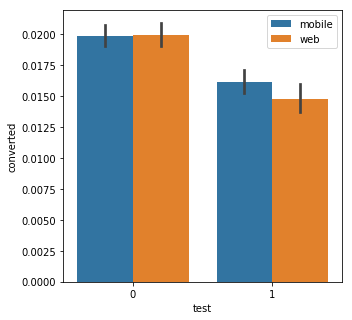

In [38]:
# Plot the average convert rate of two groups over different devices
_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='test', y='converted', hue='device', data=data_clean, ax=ax)
ax.legend(loc=1)

Text(0.5, 1.0, 'Average convert rate over device')

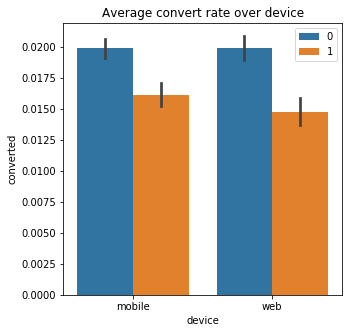

In [39]:
# Plot the average convert rate of control group and test group over different devices
_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='device', y='converted', hue='test', data=data_clean, ax=ax)
ax.legend(loc=1)
ax.set_title('Average convert rate over device')

Text(0.5, 1.0, 'Average revenue over device')

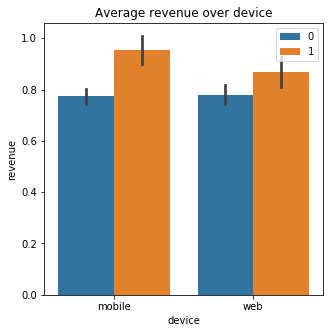

In [40]:
# Plot the average revenue of control group and test group over different devices
_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='device', y='revenue', hue='test', data=data_clean, ax=ax)
ax.legend(loc=1)
ax.set_title('Average revenue over device')

### Operating system
In this section, I will visualize the data from different sources.

In [41]:
# Calculate sample ratio for different operating system
data_temp = data[['user_id','operative_system','test']].groupby(['test','operative_system'])["user_id"].nunique().reset_index(name="ratio")
data_temp1 = data_temp.groupby(['test', 'operative_system']).agg({'ratio': 'sum'})
data_os = data_temp1.groupby(level=0).apply(lambda x: 1.0 * x / float(x.sum()))
data_os.reset_index(level = [0,1], inplace = True)
data_os.head(24)

,test,operative_system,ratio
0,0,android,0.237807
1,0,iOS,0.305115
2,0,linux,0.010887
3,0,mac,0.080729
4,0,other,0.051784
5,0,windows,0.313678
6,1,android,0.234280
7,1,iOS,0.294636
8,1,linux,0.016901
9,1,mac,0.076434


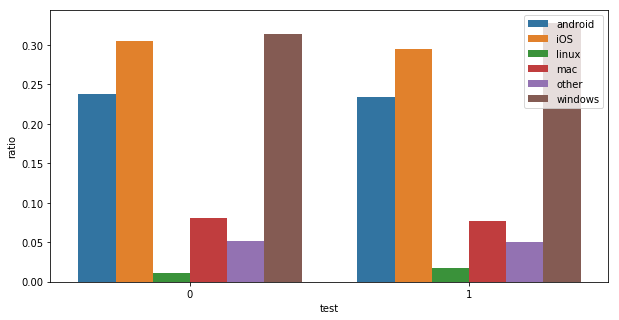

In [42]:
# Plot the sample distribution over different os using bars.
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='test', y='ratio', hue='operative_system', data=data_os, ax=ax)
ax.legend(loc=0)

Text(0.5, 1.0, 'Sample ratio over operative system')

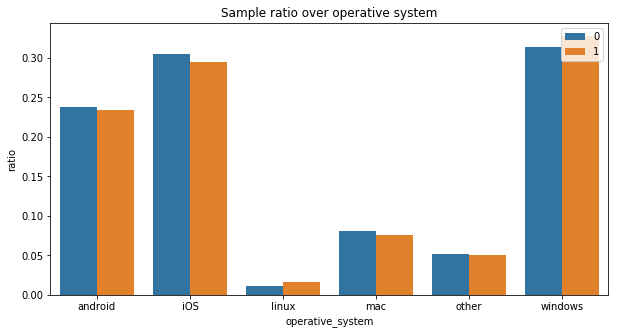

In [43]:
# Compare the sample distribution between control group and test group over different os.
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='operative_system', y='ratio', hue='test', data=data_os, ax=ax)
ax.legend(loc=1)
ax.set_title('Sample ratio over operative system')

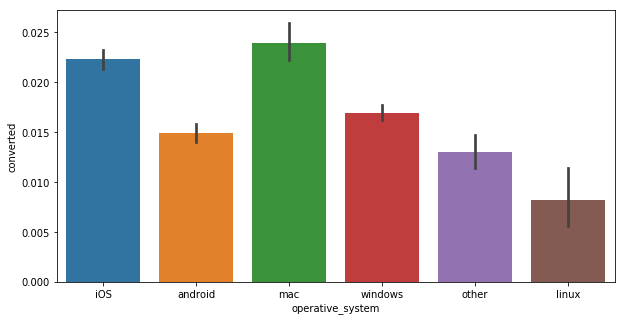

In [44]:
# Plot the average convert rate of all samples over different os
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='operative_system', y='converted', data=data_clean, ax=ax)

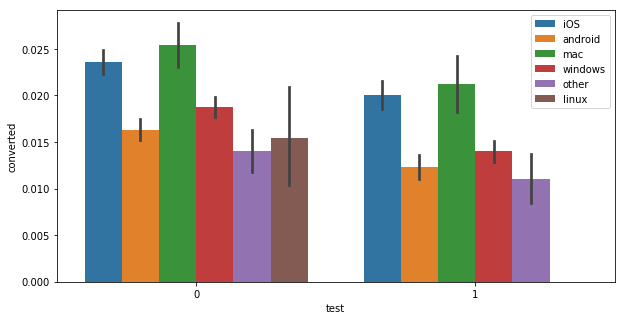

In [45]:
# Plot the average convert rate of two groups over different os
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='test', y='converted', hue='operative_system', data=data_clean, ax=ax)
ax.legend(loc=1)

Text(0.5, 1.0, 'Average convert rate over operative system')

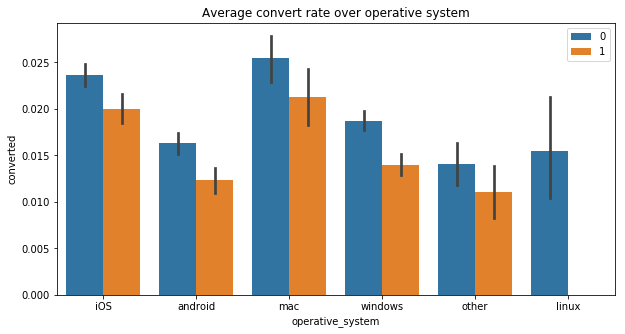

In [46]:
# Plot the average convert rate of control group and test group over different os
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='operative_system', y='converted', hue='test', data=data_clean, ax=ax)
ax.legend(loc=0)
ax.set_title('Average convert rate over operative system')

Text(0.5, 1.0, 'Average revenue over operative system')

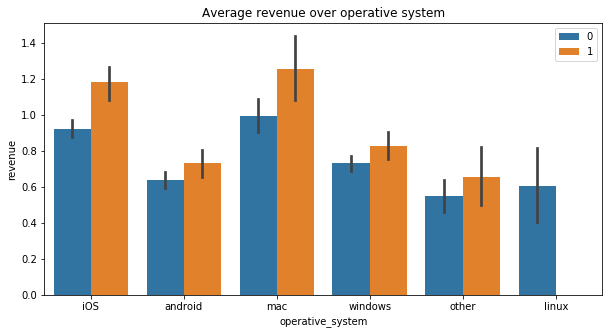

In [47]:
# Plot the average revenue of control group and test group over different os
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='operative_system', y='revenue', hue='test', data=data_clean, ax=ax)
ax.legend(loc=0)
ax.set_title('Average revenue over operative system')

#### Apple users can provide more revenue than users from other os. The convert rate of Linus users in experimental group is 0.

### Significant difference analysis

In [48]:
data_clean[["test","converted"]].groupby("test").mean()

,converted
test,
0,0.019900
1,0.015555


In [49]:
data_clean[["test","revenue"]].groupby("test").mean()

,revenue
test,
0,0.776083
1,0.917748


It is easy to understand that low price will generate higher convertion rate than high price. So we need to compare the revenue instead of direct convertion rate. Here we use the hypothesis that with a large sample size, the Bernoulli distribution can be treated as normal distribution. 
Now, let's set the hypothesis testing.
    
Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue
<br>Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [50]:
# A quick calculation of Z-test
n_control = 202727
n_test = 114073
p_control = 0.019900
p_test = 0.015555
se_control_sq = np.square(39) * p_control * (1 - p_control) / n_control
se_test_sq = np.square(59) * p_test * (1 - p_test) / n_test
z = (59 * p_test - 39 * p_control) / math.sqrt(se_test_sq+se_control_sq)
print(z)

5.718103913116789


In [51]:
control_set = data_clean.loc[data_clean['test'] == 0]['revenue'].values
test_set = data_clean.loc[data_clean['test'] == 1]['revenue'].values
print(stats.ttest_ind(control_set, test_set, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


The high Z value here is corrospoding a small p-value, which can be used to reject the Null Hypothesis. Notice that this is calculated for a two-tail hypothesis. And a one-tail test will have a even higher Z value (lower p value).
A test also shows similar results.

Now let's think about if we can end the A/B testing earlier. The first idea is to set time scale to daily or weekly.
I guess there will be a weekday and weekend difference but let's check it.

In [52]:
# Slice the first 10 chars in timestamp column to get date
results_clean = data_clean.copy()
results_clean["date"] = results_clean["timestamp"].astype(str).str[0:10]

In [53]:
results_clean["day"] = pd.DatetimeIndex(pd.to_datetime(results_clean['date'])).date

In [54]:
results_clean.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue,date,day
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0,2015-05-08,2015-05-08
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0,2015-05-10,2015-05-10
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0,2015-04-04,2015-04-04
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0,2015-05-07,2015-05-07
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0,2015-05-24,2015-05-24


In [55]:
# Group by day to get daily information
results_clean_daily = results_clean.groupby(['day','test'])['user_id'].nunique().reset_index(name="total number of users")
results_clean_daily.head()

,day,test,total number of users
0,2015-03-02,0,1011
1,2015-03-02,1,578
2,2015-03-03,0,918
3,2015-03-03,1,578
4,2015-03-04,0,952


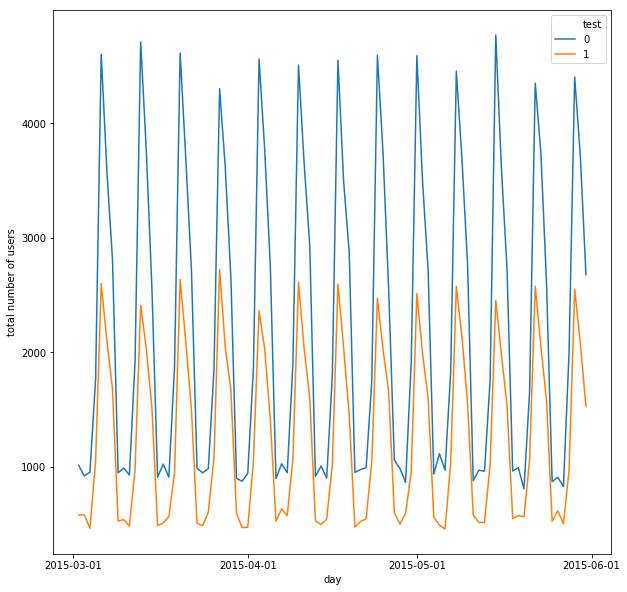

In [56]:
# plot daily samples in 2 groups
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=results_clean_daily, x='day', y='total number of users', hue='test',ax=ax)
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.legend(loc=1)

The above plot convincs me that we should think the problem in a weekly scale.

In [57]:
# Group by day to get weekly information
results_clean["date"] = pd.DatetimeIndex(pd.to_datetime(results_clean['date'])).week
results_clean.dtypes

user_id               int64
timestamp            object
source               object
device               object
operative_system     object
test                  int64
price                 int64
converted             int64
city                 object
country              object
lat                 float64
long                float64
revenue               int64
date                  int64
day                  object
dtype: object

In [58]:
test_group = results_clean.loc[results_clean["test"] == 1]
test_group.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue,date,day
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0,19,2015-05-07
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21,59,11,2015-03-15
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20,0,13,2015-03-28
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47,0,17,2015-04-24
15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59,0,Culver City,USA,34.01,-118.40,0,12,2015-03-22


In [59]:
test_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")

,date,num of user
0,10,9036
1,11,8465
2,12,8727
3,13,9104
4,14,8377
5,15,9022
6,16,8664
7,17,8724
8,18,8740
9,19,8788


In [60]:
test_num = test_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")["num of user"].cumsum().values
print(test_num)

[  9036  17501  26228  35332  43709  52731  61395  70119  78859  87647
  96229 105168 113918]


In [61]:
control_group = results_clean.loc[results_clean["test"] == 0]
control_num = control_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")["num of user"].cumsum().values
print(control_num)

[ 15638  31430  47157  62486  78127  93965 109489 125018 140630 156370
 172030 187133 202517]


In [62]:
test_crt_group = results_clean.loc[(results_clean["test"] == 1) & (results_clean["converted"] == 1)]

In [63]:
test_crt_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")

,date,num of user
0,10,157
1,11,134
2,12,141
3,13,142
4,14,119
5,15,134
6,16,135
7,17,144
8,18,113
9,19,132


In [64]:
test_crt_num = test_crt_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")["num of user"].cumsum().values
print(test_crt_num)

[ 157  291  432  574  693  827  962 1106 1219 1351 1483 1613 1772]


In [65]:
control_crt_group = results_clean.loc[(results_clean["test"] == 0) & (results_clean["converted"] == 1)]
control_crt_num = control_crt_group.groupby(['date'])['user_id'].nunique().reset_index(name = "num of user")["num of user"].cumsum().values
print(control_crt_num)

[ 331  613  927 1224 1545 1858 2185 2507 2815 3110 3438 3711 4030]


Text(0.5, 1.0, 'User numbers over weeks')

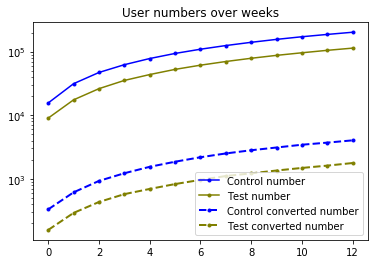

In [66]:
plt.plot(control_num, marker='.', color='blue', label='Control number')
plt.plot(test_num, marker='.', color='olive', label='Test number')
plt.plot(control_crt_num, marker='.', color='blue', linewidth=2, linestyle='dashed', label="Control converted number")
plt.plot(test_crt_num, marker='.', color='olive', linewidth=2, linestyle='dashed', label="Test converted number")
plt.yscale('log')
plt.legend()
plt.title('User numbers over weeks')

In [67]:
pvalues=[]
for j in range(13):
    print(control_crt_num[j],control_num[j], test_crt_num[j],test_num[j])
    control_set = [39 for i in range(control_crt_num[j])] + ([0 for i in range(control_num[j]-control_crt_num[j])])
    test_set = [59 for i in range(test_crt_num[j])] + ([0 for i in range(test_num[j]-test_crt_num[j])])
    t_stat,pvalue = stats.ttest_ind(control_set, test_set, axis=0, equal_var=False)
    pvalues.append(pvalue)
    print(t_stat,pvalue)

331 15638 157 9036
-2.153549702517795 0.031291794023264104
613 31430 291 17501
-3.4096096090470427 0.000651488710249819
927 47157 432 26228
-3.8964088054307253 9.778212403922973e-05
1224 62486 574 35332
-4.305424825872255 1.6694547636542434e-05
1545 78127 693 43709
-4.079289539850241 4.5223048271188666e-05
1858 93965 827 52731
-4.22259719023832 2.417520906838019e-05
2185 109489 962 61395
-4.3176091843690605 1.578798234581135e-05
2507 125018 1106 70119
-4.674634542503972 2.948132087590639e-06
2815 140630 1219 78859
-4.418002528794405 9.969804415407786e-06
3110 156370 1351 87647
-4.752269109186588 2.0134078269304876e-06
3438 172030 1483 96229
-4.832208059366748 1.3515359612771397e-06
3711 187133 1613 105168
-5.127039780993984 2.946503946535162e-07
4030 202517 1772 113918
-5.715224666463109 1.0972577312420718e-08


Text(0.5, 1.0, 'pvalue over weeks')

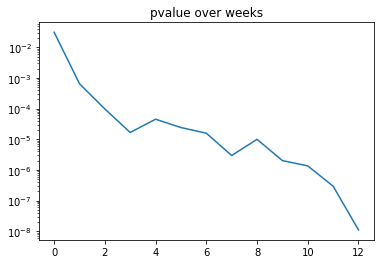

In [68]:
plt.plot(pvalues)
plt.yscale('log')
plt.title('pvalue over weeks')

From second week, we can already see a significant difference between control group and experiment group, but sometimes it will bounce back after a short period, so it may be safer to stop the A/B testing at week 5 when the p-value drops again. But if we are limited in budge, it may be also OK to stop at Week 2

In [69]:
# Calculate convert ratio for different sources
data_temp = data[['user_id','city','test']].groupby(['test','city'])["user_id"].nunique().reset_index(name="ratio")
data_temp1 = data_temp.groupby(['test', 'city']).agg({'ratio': 'sum'})
data_city = data_temp1.groupby(level=0).apply(lambda x: 1.0 * x / float(x.sum()))
data_city.reset_index(level = [0,1], inplace = True)
data_city.head(24)

,test,city,ratio
0,0,Abilene,0.001593
1,0,Akron,0.001270
2,0,Alameda,0.000595
3,0,Albany,0.002075
4,0,Albuquerque,0.000017
5,0,Alexandria,0.000493
6,0,Alhambra,0.000159
7,0,Aliso Viejo,0.000777
8,0,Allen,0.000465
9,0,Allentown,0.000930


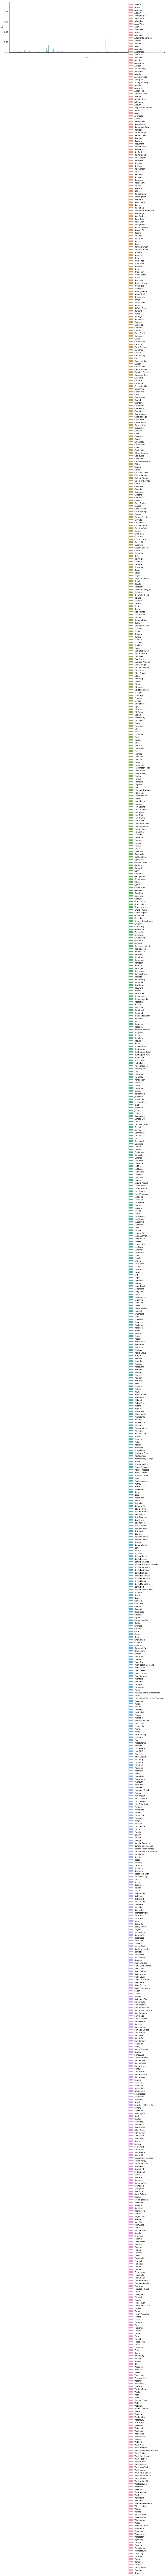

In [70]:
# Plot the sample distribution over different sources using bars.
_, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='test', y='ratio', hue='city', data=data_city, ax = ax)
ax.legend(loc=1)

In [71]:
data_city.loc[(data_city['test'] == 0) & (data_city['ratio'] > 0.01)]

,test,city,ratio
153,0,Chicago,0.026039
373,0,Houston,0.024174
382,0,Indianapolis,0.011563
391,0,Jacksonville,0.010730
464,0,Los Angeles,0.014958
548,0,New York,0.093931
718,0,San Antonio,0.016653
725,0,San Jose,0.011982


In [72]:
data_city.loc[(data_city['test'] == 1) & (data_city['ratio'] > 0.01)]

,test,city,ratio
1072,1,Chicago,0.025799
1291,1,Houston,0.024610
1300,1,Indianapolis,0.011866
1309,1,Jacksonville,0.010203
1383,1,Los Angeles,0.015143
1464,1,New York,0.092511
1633,1,San Antonio,0.017089
1640,1,San Jose,0.012502


In [73]:
data_city.loc[data_city["test"] == 0].nlargest(8, 'ratio')

,test,city,ratio
548,0,New York,0.093931
153,0,Chicago,0.026039
373,0,Houston,0.024174
718,0,San Antonio,0.016653
464,0,Los Angeles,0.014958
725,0,San Jose,0.011982
382,0,Indianapolis,0.011563
391,0,Jacksonville,0.010730


In [74]:
data_city.loc[data_city["test"] == 1].nlargest(8, 'ratio')

,test,city,ratio
1464,1,New York,0.092511
1072,1,Chicago,0.025799
1291,1,Houston,0.024610
1633,1,San Antonio,0.017089
1383,1,Los Angeles,0.015143
1640,1,San Jose,0.012502
1300,1,Indianapolis,0.011866
1309,1,Jacksonville,0.010203


The top 8 cities of users are the same in 2 groups.

Text(0.5, 1.0, 'Average convert rate over top 8 cities')

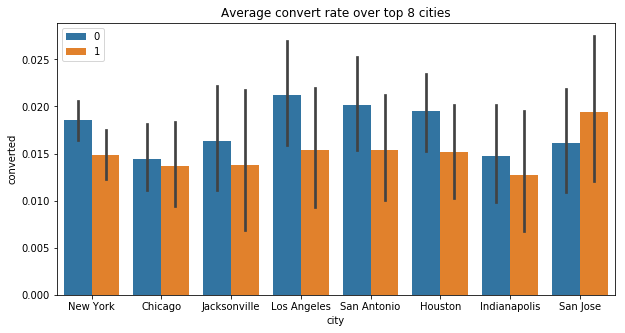

In [75]:
top8_cities = ['New York', 'Chicago', 'Houston','San Antonio', 'Los Angeles', 'San Jose', 'Indianapolis', 'Jacksonville']
# Plot the average convert rate of control group and test group over different cities
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='city', y='converted', hue='test', data=data_clean.loc[data_clean['city'].isin(top8_cities)], ax=ax)
ax.legend(loc=0)
ax.set_title('Average convert rate over top 8 cities')

Text(0.5, 1.0, 'Average revenue over top 8 cities')

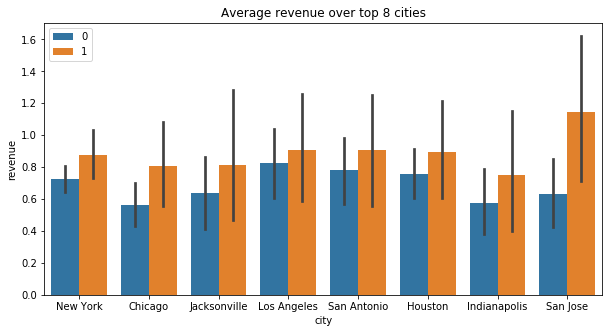

In [76]:
# Plot the average revenue of control group and test group over different os
_, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='city', y='revenue', hue='test', data=data_clean.loc[data_clean['city'].isin(top8_cities)], ax=ax)
ax.legend(loc=0)
ax.set_title('Average revenue over top 8 cities')